## Example Program

In [19]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import xml.etree.ElementTree as ET
import glob
from PIL import Image
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns 
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import torch
from Yolo.detect_face import get_faces_bbox
from Yolo.models.experimental import attempt_load
from tqdm import tqdm

In [20]:
DATASET_DIR = "Dataset"

smallest = 224
for folder in os.listdir(DATASET_DIR):
    for im in tqdm(os.listdir(os.path.join(DATASET_DIR,folder))):
        example = cv2.imread(os.path.join(DATASET_DIR,folder,im))
        ex_h, ex_w, _ = example.shape
        if(ex_h < smallest):
            smallest = ex_h
        if(ex_w < smallest):
            smallest = ex_w
smallest

100%|██████████| 2994/2994 [00:02<00:00, 1451.02it/s]


128

## Tensorflow Load Data

In [21]:
DATASET_DIR = "Dataset"
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=67.5,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="wrap",
                                    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(directory=DATASET_DIR,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        target_size=(128, 128),
                                                        subset='training')

validation_generator = train_datagen.flow_from_directory(directory=DATASET_DIR,
                                                            batch_size=BATCH_SIZE,
                                                            class_mode='categorical',
                                                            target_size=(128, 128),
                                                            subset='validation')

Found 7188 images belonging to 3 classes.
Found 1794 images belonging to 3 classes.


## Create Model

In [23]:
## Test 1
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (128,128,3)))
model.add(layers.MaxPooling2D(pool_size = 2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = 2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = 2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters = 128, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = 2))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(units = 256, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units = 3, activation = 'softmax'))
model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_27 (Bat  (None, 64, 64, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                      

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['acc'])
    
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history_train = model.fit(train_generator,validation_data=validation_generator,epochs=100,verbose=1,callbacks=callbacks)

Epoch 1/100
225/225 [==============================] - 42s 180ms/step - loss: 0.6300 - acc: 0.8027 - val_loss: 4.5293 - val_acc: 0.3439
Epoch 2/100
225/225 [==============================] - 40s 176ms/step - loss: 0.3701 - acc: 0.8612 - val_loss: 0.9578 - val_acc: 0.7625
Epoch 3/100
225/225 [==============================] - 38s 166ms/step - loss: 0.3012 - acc: 0.8908 - val_loss: 0.2705 - val_acc: 0.9052
Epoch 4/100
225/225 [==============================] - 38s 170ms/step - loss: 0.2537 - acc: 0.9046 - val_loss: 0.2562 - val_acc: 0.9091
Epoch 5/100
225/225 [==============================] - 35s 154ms/step - loss: 0.2318 - acc: 0.9174 - val_loss: 0.3427 - val_acc: 0.8712
Epoch 6/100
225/225 [==============================] - 35s 156ms/step - loss: 0.2078 - acc: 0.9233 - val_loss: 0.3483 - val_acc: 0.8735
Epoch 7/100
225/225 [==============================] - 36s 158ms/step - loss: 0.2018 - acc: 0.9282 - val_loss: 0.2743 - val_acc: 0.8913
Epoch 8/100
225/225 [===========================

In [25]:
model.save('cnn 2-2M 128 RGB.h5')

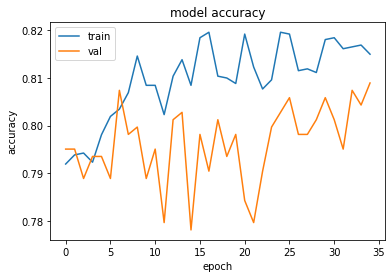

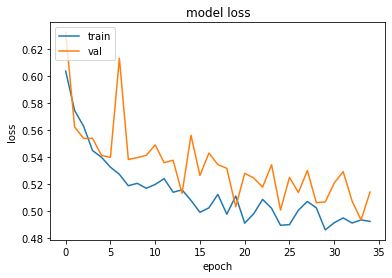

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history_train.history['acc'])
plt.plot(history_train.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()
plt.plot(history_train.history['loss'])
plt.plot(history_train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Eval

In [10]:
def Num2Label(num):
    if num == 0:
        return "incorrect_mask"
    elif num == 1:
        return "with_mask"
    else:
        return "without_mask"

In [11]:
def getAktualFromGen(generator,b_size):
    number_of_examples = len(generator.filenames)
    number_of_generator_calls = math.ceil(number_of_examples / (1.0 * b_size)) 
    labels = []

    for i in range(0,int(number_of_generator_calls)):
        labels.extend(np.array(generator[i][1]))
    return labels

### Train

In [12]:
## Aktual
train_aktual = np.argmax(getAktualFromGen(train_generator,BATCH_SIZE), axis=1)

## Predictions
train_pred = model.predict(train_generator)
y_train = np.argmax(train_pred, axis=1)

82/82 [==============================] - 3s 34ms/step


In [13]:
confusion_matrix(train_aktual, y_train)

array([[   0,   70,    9],
       [   0, 1984,   84],
       [   0,  320,  138]], dtype=int64)

In [14]:
target_names = ['incorrect_mask', 'with_mask', 'without_mask']
print(classification_report(y_train, train_aktual, target_names=target_names))

                precision    recall  f1-score   support

incorrect_mask       0.00      0.00      0.00         0
     with_mask       0.96      0.84      0.89      2374
  without_mask       0.30      0.60      0.40       231

      accuracy                           0.81      2605
     macro avg       0.42      0.48      0.43      2605
  weighted avg       0.90      0.81      0.85      2605



c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

### validation

In [15]:
## Aktual
val_aktual = np.argmax(getAktualFromGen(validation_generator,BATCH_SIZE), axis=1)

## Predictions
val_pred = model.predict(validation_generator)
y_val = np.argmax(val_pred, axis=1)

21/21 [==============================] - 1s 45ms/step


In [16]:
confusion_matrix(val_aktual, y_val)

array([[  0,  17,   2],
       [  0, 503,  13],
       [  0,  97,  17]], dtype=int64)

In [17]:
target_names = ['incorrect_mask', 'with_mask', 'without_mask']
print(classification_report(y_val, val_aktual, target_names=target_names))

                precision    recall  f1-score   support

incorrect_mask       0.00      0.00      0.00         0
     with_mask       0.97      0.82      0.89       617
  without_mask       0.15      0.53      0.23        32

      accuracy                           0.80       649
     macro avg       0.37      0.45      0.37       649
  weighted avg       0.93      0.80      0.86       649



c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

### Test

In [18]:
## Aktual
test_aktual = np.argmax(getAktualFromGen(test_generator,1), axis=1)

## Predictions
test_pred = model.predict(test_generator)
y_test = np.argmax(test_pred, axis=1)

815/815 [==============================] - 2s 3ms/step


In [19]:
confusion_matrix(test_aktual, y_test)

array([[  0,  22,   3],
       [  0, 634,  13],
       [  0,  95,  48]], dtype=int64)

In [20]:
target_names = ['incorrect_mask', 'with_mask', 'without_mask']
print(classification_report(y_test, test_aktual, target_names=target_names))

                precision    recall  f1-score   support

incorrect_mask       0.00      0.00      0.00         0
     with_mask       0.98      0.84      0.91       751
  without_mask       0.34      0.75      0.46        64

      accuracy                           0.84       815
     macro avg       0.44      0.53      0.46       815
  weighted avg       0.93      0.84      0.87       815



c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\asus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

## Inference

In [6]:
def BGR2RGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def Num2Label(num):
    if num == 0:
        return "incorrect_mask",(255, 255, 0)
    elif num == 1:
        return "with_mask",(0, 255, 0)
    elif num == 2:
        return "without_mask",(0, 0, 255)
    else:
        raise ValueError("Invalid number")

Fusing layers... 
8 faces


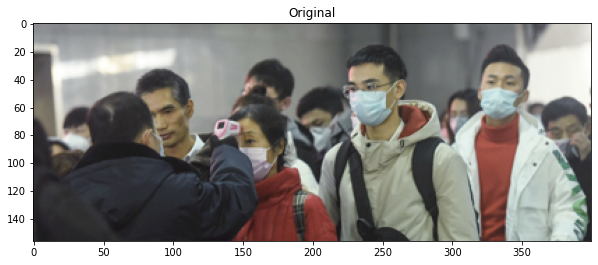

[319.0, 29.0, 352.0, 67.0]
1/1 [==============================] - 0s 94ms/step
[76.0, 49.0, 111.0, 89.0]
1/1 [==============================] - 0s 23ms/step
[224.0, 29.0, 259.0, 73.0]
1/1 [==============================] - 0s 21ms/step
[367.0, 66.0, 398.0, 99.0]
1/1 [==============================] - 0s 22ms/step
[135.0, 69.0, 170.0, 110.0]
1/1 [==============================] - 0s 25ms/step
[297.0, 54.0, 319.0, 84.0]
1/1 [==============================] - 0s 20ms/step
[145.0, 36.0, 176.0, 74.0]
1/1 [==============================] - 0s 29ms/step
[189.0, 61.0, 218.0, 91.0]
1/1 [==============================] - 0s 22ms/step


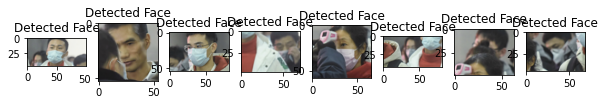

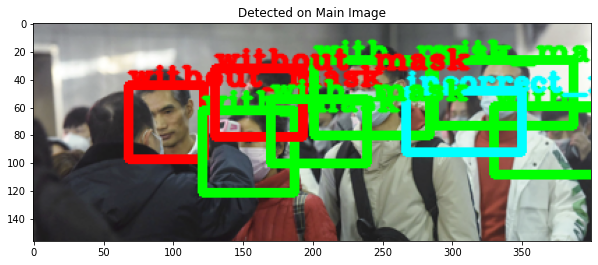

In [14]:
pred_file = "images\maksssksksss1.png"

%matplotlib inline 
plt.figure(figsize=(10,10))
image = cv2.imread(pred_file)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo_model = attempt_load('Yolo/yolov5m-face.pt', map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")) 
faces = get_faces_bbox(image,yolo_model,device)
height, width, colors = image.shape

plt.imshow(BGR2RGB(image))
plt.title("Original")

plt.show()
plt.figure(figsize=(10,10))

annotated_img = image.copy()
mask_model = tf.keras.models.load_model('cnn_model.h5')
for idx,face in enumerate(faces):
    plt.subplot(1,len(faces),idx+1)
    rgb_im = BGR2RGB(image)

    print(face)
    tolerance = 0.1
    face_start_point = int(face[0]*(1-tolerance)),int(face[1]*(1-tolerance))
    face_end_point = int(face[2]*(1+tolerance)),int(face[3]*(1+tolerance))
    cropped_image = rgb_im[face_start_point[1]:face_end_point[1],face_start_point[0]:face_end_point[0]]
    plt.imshow(cropped_image)
    plt.title("Detected Face")


    pred_image = tf.image.resize(cropped_image, [128,128], method=tf.image.ResizeMethod.BICUBIC)
    pred_image = pred_image/255.0
    pred_image = tf.expand_dims(pred_image, axis=0)
    pred = np.argmax(mask_model.predict(pred_image), axis=1)

    label,color = Num2Label(pred[0])
    cv2.rectangle(annotated_img, face_start_point, face_end_point, color, 5)
    cv2.putText(annotated_img, label, face_start_point, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, color, 2, cv2.LINE_AA)

plt.figure(figsize=(10,10))
plt.imshow(BGR2RGB(annotated_img))
plt.title("Detected on Main Image")
plt.show()